In [158]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import scipy.sparse as scps
import scipy.sparse.linalg as ssl
import math

In [159]:
def maillage_carre(n: int):
    """
    Une discrétisation possible d'une EDP elliptique sur le domaine ]0,1[ x ]0,1[.
    Le carre [0,1]x[0,1] est maille uniquement avec des triangles.
    Les conditions limites sont de type Dirichlet uniquement -> `neumann=[]`.

    Args:
        n (int): nombre de points par cote du care => Npts points de discretisation au total

    Returns:
        coordinates : matrice a deux colonnes. Chaque ligne contient les coordonnes 2D d'un des points de la discretisation. Ces sommets seront identifies a l'indice de la ligne correspondante dans la matrice coordinates.
        elements3 : matrice a trois colonnes. Chaque ligne contient les indices des sommets d'un element triangle, dans le sens antihoraire.
        dirichlet : vecteur colonne des indices des sommets de la frontiere de Dirichlet.
        neumann : matrice a deux colonnes. Chaque ligne contient les indices des deux sommets d'une arete de la frontiere de Neumann. (neumann est vide sur cet exemple)
    """

    h = 1 / (n - 1)
    n_pts = n * n
    n_elm = 2 * (n - 1) * (n - 1)
    coordinates = np.zeros((n_pts, 2))
    elements3 = np.zeros((n_elm, 3), dtype=int)
    neumann = []
    dirichlet = np.zeros((4 * n - 4, 1), dtype=int)

    # Coordonnees et connectivites :
    e = -1
    p = -1
    x = np.zeros((n + 1, 1))
    x[n, 0] = 1.0

    for l in range(n + 1):
        x[l, 0] = l * h

    for j in range(n):
        for i in range(n):
            p = p + 1
            coordinates[p, 0] = x[i, 0]
            coordinates[p, 1] = x[j, 0]
            if (i != n - 1) & (j != n - 1):
                p1 = p
                p2 = p1 + 1
                p3 = p1 + n
                p4 = p2 + n
                e = e + 1
                elements3[e, 0] = p1
                elements3[e, 1] = p2
                elements3[e, 2] = p3
                e = e + 1
                elements3[e, 0] = p4
                elements3[e, 1] = p3
                elements3[e, 2] = p2

    # Liste des sommets de la frontiere de Dirichlet:
    p = -1
    for j in range(n):
        p = p + 1
        dirichlet[p, 0] = j

    for j in range(n * 2 - 1, n * (n - 1), n):
        p = p + 1
        dirichlet[p, 0] = j

    for j in range(n * n - 1, n * n - n - 1, -1):
        p = p + 1
        dirichlet[p, 0] = j

    for j in range(n * n - 2 * n, n - 1, -n):
        p = p + 1
        dirichlet[p, 0] = j

    return coordinates, elements3, dirichlet, neumann


In [160]:
def show(coordinates, u) -> None:
    """Fonction d'affichage de la solution u sur le maillage defini par elements3, coordinates.

    Args:
        elements3 : matrice a trois colonnes contenant les elements triangles de la discretisation, identifies par les indices de leurs trois sommets.
        coordinates : matrice a deux colonnes contenant les coordonnes 2D des points de la discretisation.
        u : vecteur colonne de longueur egale au nombre de lignes de coordinates contenant les valeurs de la solution a afficher aux points de la discretisation.

    Returns:
        None, plots a figure
    """

    ax = plt.figure().add_subplot(projection="3d")
    ax.plot_trisurf(
        coordinates[:, 0], coordinates[:, 1], u, linewidth=0.2, antialiased=True
    )
    plt.show()

**Partie I : maillage triangulaire et conditions de Dirichlet**


In [161]:
def f(x, y):
    # return 2 * np.pi ** 2 * np.sin(np.pi * x) * np.sin(np.pi * y)
    try:
        return np.ones(x.shape[0])
    except:
        return 1


def u_ex(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)


def u_d(x, y):
    # return np.zeros(x.shape[0])
    # return 1
    return np.ones(x.shape[0])

def g(x):
    # return np.cos(x)
    return 1

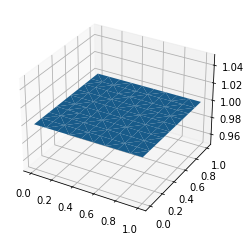

In [162]:
n = 10
coords, elems3, dirichlet, neumann = maillage_carre(n)
show(coords, f(coords[:, 0], coords[:, 1]))
# show(coords, u_ex(coords[:, 0], coords[:, 1]))
# print(maillage_carre(3))

In [163]:
def raideur(triangle):
    M = np.zeros((3, 3))
    x = triangle[:, 0]
    y = triangle[:, 1]

    # calcul de alpha
    mat_alpha = np.array(
        [
            [x[1] - x[0], x[2] - x[0]],
            [y[1] - y[0], y[2] - y[0]]
        ]
    )
    alpha = np.linalg.det(mat_alpha)


    for i in range(3):
        grad_eta_i = np.array(
            [
                y[(i+1)%3] - y[(i+2)%3],
                x[(i+2)%3] - x[(i+1)%3]
            ]
        )
        for j in range(3):
            grad_eta_j = np.array(
                [
                    y[(j+1)%3] - y[(j+2)%3],
                    x[(j+2)%3] - x[(j+1)%3]
                ]
            )

            M[i, j] = np.dot(grad_eta_i, grad_eta_j)

    return M / alpha / 2

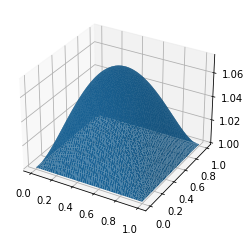

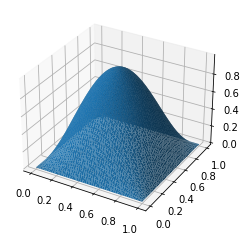

In [164]:
def assemblage(coords, elems3):
    Ns = len(coords)
    A = np.zeros((Ns, Ns))
    for triangle in elems3:
        M = raideur(coords[triangle])
        for i, a in enumerate(triangle):
            for j, b in enumerate(triangle):
                A[a, b] += M[i, j]
    return A


def second_membre(coords, elem3, f):
    Ns = len(coords)
    b = np.zeros(Ns)
    for triangle in elem3:
        coords_triangle = coords[triangle]
        centre = np.mean(coords_triangle, 0)

        # calcul de alpha
        x = coords_triangle[:, 0]
        y = coords_triangle[:, 1]
        mat_alpha = np.array([[x[1] - x[0], x[2] - x[0]], [y[1] - y[0], y[2] - y[0]]])
        alpha = np.linalg.det(mat_alpha)

        b[triangle] += alpha / 6 * f(centre[0], centre[1])

    return b


def calcul_Ud(coords, dirichlet):
    Ns = len(coords)
    U = np.zeros(Ns)
    # for d in dirichlet:
    #     x, y = coords[d].flatten()
    #     U[d] = u_d(x, y)
    U[dirichlet.T] = u_d(coords[dirichlet, 0], coords[dirichlet, 1])

    return U


def tildage(A, b, coords, dirichlet):
    A_tild = np.delete(A, dirichlet, 0)
    A_tild = np.delete(A_tild, dirichlet, 1)
    b_tild = np.delete(b, dirichlet, 0)
    coords_tild = np.delete(coords, dirichlet, 0)

    return A_tild, b_tild, coords_tild


def untildage(x, dirichlet, U_d):
    x_untild = np.zeros(U_d.shape[0])
    not_dirichlet = np.setdiff1d(range(U_d.shape[0]), dirichlet)

    # print(x_untild)
    # print(not_dirichlet)
    # print(dirichlet)
    # print(x)

    x_untild[dirichlet] = U_d[dirichlet]
    x_untild[not_dirichlet] = x

    return x_untild

n = 50
coords, elems3, dirichlet, neumann = maillage_carre(n)

A = assemblage(coords, elems3)
b = second_membre(coords, elems3, f)
U_d = calcul_Ud(coords, dirichlet)
b -= np.dot(A, U_d)

A_tild, b_tild, coords_tild = tildage(A, b, coords, dirichlet)

x = np.linalg.solve(A_tild, b_tild)
x_untild = untildage(x, dirichlet, U_d)

# show(coords_tild, x)
# print(coords.shape, x_untild.shape)
# print(coords, x_untild)
show(coords, x_untild)
show(coords, u_ex(coords[:, 0], coords[:, 1]))

**Partie II : maillage mixte et ajoût des conditions de Neumann**


In [165]:
e3 = np.array(
    [[1, 2, 12], [2, 3, 12], [3, 4, 14], [4, 5, 14], [2, 15, 3], [3, 15, 4]]
).astype(int)

e4 = np.array(
    [
        [0, 1, 12, 11],
        [11, 12, 13, 10],
        [12, 3, 14, 13],
        [10, 13, 8, 9],
        [13, 14, 7, 8],
        [14, 5, 6, 7],
    ]
).astype(int)

dds = np.array([2, 15, 4, 6, 7, 8, 9, 10, 11, 0]).astype(int)

nns = np.array([[4, 5], [5, 6], [0, 1], [1, 2]]).astype(int)

ccs = np.array(
    [
        [0.0, 0.0],
        [1 / 3, 0],
        [0.53333333333333, 0.0],
        [2 / 3, 1 / 3],
        [1.0, 0.47],
        [1, 2 / 3],
        [1.0, 1.0],
        [2 / 3, 1.0],
        [1 / 3, 1.0],
        [0.0, 1.0],
        [0.0, 2 / 3],
        [0.0, 1 / 3],
        [1 / 3, 1 / 3],
        [1 / 3, 2 / 3],
        [2 / 3, 2 / 3],
        [1.0, 0.0],
    ]
)

In [166]:
def raideur_quadrangle(quadrangle):
    x = quadrangle[:, 0]
    y = quadrangle[:, 1]

    # calcul de la jacobienne
    J_kk = np.array([[x[1] - x[0], x[3] - x[0]], [y[1] - y[0], y[3] - y[0]]])

    det_J_kk = np.linalg.det(J_kk)

    # on récupère les coefficients
    coeffs = np.linalg.inv(np.matmul(J_kk.T, J_kk))
    a = coeffs[0, 0]
    b = coeffs[0, 1]
    c = coeffs[1, 1]

    # on calcul M (on a calculé toutes les intégrales au préalable)
    M = np.array(
        [
            [2 * a + 3 * b + 2 * c, -2 * a + c, -a - 3 * b - c, a - 2 * c],
            [-2 * a + c, 2 * a - 3 * b + 2 * c, a - 2 * c, -a + 3 * b - c],
            [-a - 3 * b - c, a - 2 * c, 2 * a + 3 * b + 2 * c, -2 * a + c],
            [a - 2 * c, -a + 3 * b - c, -2 * a + c, 2 * a - 3 * b + 2 * c],
        ]
    )

    return det_J_kk / 6 * M

raideur_quadrangle(ccs[e4[0]])

array([[ 0.66666667, -0.16666667, -0.33333333, -0.16666667],
       [-0.16666667,  0.66666667, -0.16666667, -0.33333333],
       [-0.33333333, -0.16666667,  0.66666667, -0.16666667],
       [-0.16666667, -0.33333333, -0.16666667,  0.66666667]])

**Compléments d'analyse du système**


[-0.30555556  1.63888889 -1.67777778  2.11685185 -1.69356874  1.65116133
 -0.30555556 -0.94444444 -0.61111111 -0.30555556 -0.61111111 -0.94444444
  1.31296296  1.77777778  1.31777778 -0.35296296]


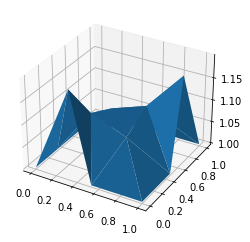

In [167]:
def assemblage_quadrangle(coords, elems4):
    Ns = len(coords)
    A = np.zeros((Ns, Ns))
    for quadrangle in elems4:
        M = raideur_quadrangle(coords[quadrangle])
        for i, a in enumerate(quadrangle):
            for j, b in enumerate(quadrangle):
                A[a, b] += M[i, j]
    return A

def second_membre_quadrangle(coords, elem4, f):
    Ns = len(coords)
    b = np.zeros(Ns)
    for quadrangle in elem4:
        coords_triangle = coords[quadrangle]
        centre = np.mean(coords_triangle, 0)

        # calcul de alpha
        x = coords_triangle[:, 0]
        y = coords_triangle[:, 1]
        mat_alpha = np.array([[x[1] - x[0], x[2] - x[0]], [y[1] - y[0], y[2] - y[0]]])
        alpha = np.linalg.det(mat_alpha)

        b[quadrangle] += alpha / 4 * f(centre[0], centre[1])

    return b

def condition_neumann(ccs, nns):
    Ns = len(ccs)
    coeffs = np.zeros(Ns)
    for i, j in nns:
        point1 = ccs[i]
        point2 = ccs[j]
        
        valeur = np.linalg.norm(point1 - point2) / 2 * g((point1 + point2) / 2)
        coeffs[i] += valeur
        coeffs[j] += valeur

    return coeffs

#------------------------------------------------------------------------------------------------------------------------

A3 = assemblage(ccs, e3)
A4 = assemblage_quadrangle(ccs, e4)

b3 = second_membre(ccs, e3, f)
b4 = second_membre_quadrangle(ccs, e4, f)

A = A3 + A4
b = b3 + b4

# print(A)

U_d = calcul_Ud(ccs, dds)
b -= np.dot(A, U_d)
b += condition_neumann(ccs, nns)
print(b)

# print(b3)
# print(b4)

# A_tild, b_tild, ccs_tild = tildage_quadrangle(A, b, ccs, dds, nns)
A_tild, b_tild, ccs_tild = tildage(A, b, ccs, dds)

x = np.linalg.solve(A_tild, b_tild)
# print(x)
x_untild = untildage(x, dds, U_d)

# print(A)
# print(b)
# print(U_d)
show(ccs, x_untild)
# show(ccs, u_ex(ccs[:, 0], ccs[:, 1]))